# Прогнозирование кредита на основе поведения клиента

### Датасет представляет собой описание портретов потребителей, которые обращались в компанию за кредитом. Задача состоит в том, чтобы создать портрет потенциальных неплательщиков кредита, чтобы в дальнейшем уменьшить риски для компании при выдаче новых кредитов.

#### Переменные: 
##### income - годовой доход клиента в рупиях
##### age - возраст клиента
##### experience - рабочий стаж
##### profession - профессия
##### married - семейный статус (состоит в браке или нет)
##### house_ownership - владение или аренда имущества
##### car_ownership - наличие автомобиля
##### risk_flag - неуплата кредита
##### current job years - стаж работы на текущем месте
##### current house years - кол-во лет в настоящем месте проживания
##### city - город проживания
##### state - штат проживания

In [1]:
import numpy as np
import pandas as pd

In [2]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
loan = pd.read_csv('Training Data.csv')
loan

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251996,251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251997,251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0
251998,251999,6507128,45,0,single,rented,no,Graphic_Designer,Pondicherry,Puducherry,0,10,0


In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


### Итак, в данном датасете 252000 строк и 13 переменных, 7 из которых количественные, 6 - качественные. Пропусков нет.

### Для выявления связи между количественными переменными можно было бы воспользоваться корреляционным анализом. Однако, переменные Income, Age, Experience, Current_Job_Yrs, Current_House_Yrs измеренны по шкале отношений, а переменная Risk_Flag является биноминальной. А нам собственно и нужно увидеть, как на Risk_Flag влияют остальные переменные. Однако, корреляционный анализ в данном не даст особого результата. См. таблицу ниже. 

In [5]:
loan.corr()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,1.000000,-0.001324,-0.001816,-0.005810,-0.003250,0.001972,0.032153
Income,-0.001324,1.000000,-0.000652,0.006422,0.007045,-0.002397,-0.003091
Age,-0.001816,-0.000652,1.000000,-0.001118,0.002154,-0.020134,-0.021809
Experience,-0.005810,0.006422,-0.001118,1.000000,0.646098,0.019309,-0.034523
CURRENT_JOB_YRS,-0.003250,0.007045,0.002154,0.646098,1.000000,0.005372,-0.016942
CURRENT_HOUSE_YRS,0.001972,-0.002397,-0.020134,0.019309,0.005372,1.000000,-0.004375
Risk_Flag,0.032153,-0.003091,-0.021809,-0.034523,-0.016942,-0.004375,1.000000


#### Мы видим, что связь между Risk_Flag и остальными признаками практически отсутствует, хотя по-мнению автора, очевидно, что связь между доходом и неуплатой кредита существует.

### Попробуем проанализировать данные по-другому

### Найдём число клиентов, не выплативших кредит и посмотрим, какую долю оно составляет от общего числа клиентов.
### Для этого отфильтруем датасет по колонке Risk_Flag

In [6]:
loan[loan['Risk_Flag'] == 1].shape

(30996, 13)

### Из 252 тысяч клиентов неплательщиками кредитов являются 30996 - 12,3%.
### В дальнейшем будем анализировать только данные неплательщиков и попробуем составить их портрет

#### Присвоим отфильтрованному датасету новое имя

In [7]:
defaulters = loan[loan['Risk_Flag'] == 1]
defaulters

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
14,15,9420838,48,6,single,rented,no,Technical_writer,Madurai,Tamil_Nadu,6,10,1
17,18,3666346,56,12,single,rented,no,Politician,Bhusawal,Maharashtra,12,11,1
28,29,8832725,64,5,single,rented,no,Biomedical_Engineer,Pondicherry,Puducherry,5,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251973,251974,1244622,35,15,single,rented,no,Psychologist,Alwar,Rajasthan,3,11,1
251977,251978,1330613,63,19,single,rented,no,Engineer,Purnia[26],Bihar,13,12,1
251981,251982,1796713,47,2,single,rented,no,Technician,Kolhapur,Maharashtra,2,12,1
251982,251983,3182290,52,2,single,rented,no,Drafter,Naihati,West_Bengal,2,10,1


### Проанализируем описательные статистики по колонкам с количественными данными (кроме ID, Risk_Flag)

In [8]:
defaulters[['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']].describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
count,3.099600e+04,30996.00000,30996.000000,30996.000000,30996.000000
mean,4.973359e+06,48.96035,9.531101,6.168893,11.981449
std,2.921065e+06,17.36874,6.071810,3.748200,1.400140
min,1.067500e+04,21.00000,0.000000,0.000000,10.000000
25%,2.421029e+06,33.00000,4.000000,3.000000,11.000000
50%,4.977653e+06,49.00000,9.000000,6.000000,12.000000
75%,7.556052e+06,64.00000,15.000000,9.000000,13.000000
max,9.994501e+06,79.00000,20.000000,14.000000,14.000000


### Слишком большое среднеквадратическое отклонение по возрасту

<AxesSubplot:>

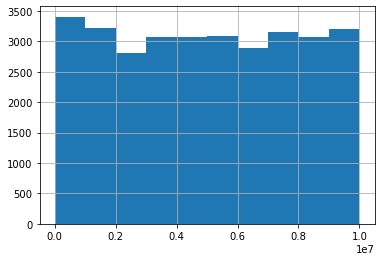

In [9]:
defaulters['Income'].hist()

#### Мы видим по гистограмме, что переменная доход имеет мультимодальное распределение. Можно это подтвердить с помощью функции mode()

In [10]:
defaulters['Income'].mode()

0     700444
1    1362373
2    3154685
3    3424035
4    6715263
Name: Income, dtype: int64

In [11]:
### Создадим новую категориальную переменную income

In [25]:
def get_inc_cat(inc):
    if inc < 500000:
        return 'Низкий'
    elif inc <3500000:
        return 'Ниже среднего'
    elif inc <5500000:
        return 'Средний'
    elif inc < 7500000:
        return 'Высокий'
    elif inc >= 7500000:
        return 'Очень высокий'
    else:
        return inc

In [26]:
defaulters['Income category'] = defaulters['Income'].apply(get_inc_cat)

C:\Users\hp\AppData\Local\Temp\ipykernel_14456\2401456954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulters['Income category'] = defaulters['Income'].apply(get_inc_cat)


In [27]:
defaulters['Income category'] = pd.Categorical(defaulters['Income category'])

C:\Users\hp\AppData\Local\Temp\ipykernel_14456\2320997086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulters['Income category'] = pd.Categorical(defaulters['Income category'])


In [28]:
defaulters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30996 entries, 3 to 251993
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Id                 30996 non-null  int64   
 1   Income             30996 non-null  int64   
 2   Age                30996 non-null  int64   
 3   Experience         30996 non-null  int64   
 4   Married/Single     30996 non-null  object  
 5   House_Ownership    30996 non-null  object  
 6   Car_Ownership      30996 non-null  object  
 7   Profession         30996 non-null  object  
 8   CITY               30996 non-null  object  
 9   STATE              30996 non-null  object  
 10  CURRENT_JOB_YRS    30996 non-null  int64   
 11  CURRENT_HOUSE_YRS  30996 non-null  int64   
 12  Risk_Flag          30996 non-null  int64   
 13  Income category    30996 non-null  category
dtypes: category(1), int64(7), object(6)
memory usage: 3.3+ MB


In [29]:
defaulters.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Income category
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Высокий
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Высокий
14,15,9420838,48,6,single,rented,no,Technical_writer,Madurai,Tamil_Nadu,6,10,1,Очень высокий
17,18,3666346,56,12,single,rented,no,Politician,Bhusawal,Maharashtra,12,11,1,Средний
28,29,8832725,64,5,single,rented,no,Biomedical_Engineer,Pondicherry,Puducherry,5,11,1,Очень высокий


In [30]:
defaulters['Income category'].value_counts()

Ниже среднего    9283
Очень высокий    7913
Высокий          6120
Средний          5899
Низкий           1781
Name: Income category, dtype: int64

<AxesSubplot:>

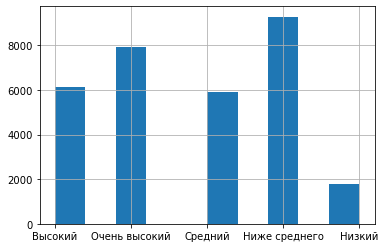

In [31]:
defaulters['Income category'].hist()

### Мы видим, что неплательщиками в основном являются люди с доходом ниже среднего, либо с очень высоким доходом. Это связано со спецификой страны (Индия) - много людей за чертой бедности и много людей с высоким доходом.

### Можно сделать предположение, что клиенты могли указать высокий доход с помощью кредитных специалистов или иными путями, но изначально платить этот кредит не собирались - мошенники. По-поводу неплательщиков с доходом ниже среднего можно предположить, что у клиентов проблемы с дисциплиной (постоянно опаздывает с выплатами), клиент попал в финансовую пирамиду (берёт новый кредит, чтобы погасить предыдущий и не успевает выплачивать).

### Для проверки этих предположений, к сожалению, не хватает данных.

### Перейдём к следующим переменным

In [33]:
defaulters['Age'].describe()

count    30996.00000
mean        48.96035
std         17.36874
min         21.00000
25%         33.00000
50%         49.00000
75%         64.00000
max         79.00000
Name: Age, dtype: float64

<AxesSubplot:>

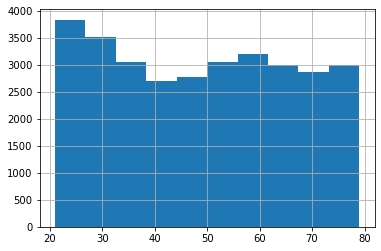

In [32]:
defaulters['Age'].hist()

### Основные неплательщики находятся в возрасте от 21 до 33 лет, хотя ярко выделяющейся возрастной группы нет

<AxesSubplot:>

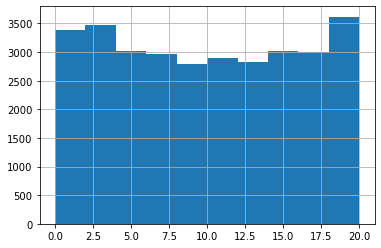

In [34]:
defaulters['Experience'].hist()

### По опыту работы нельзя выделить какую-то конкретную группу, которая не платит чаще всего. Примерно все на одном уровне.

<AxesSubplot:ylabel='Married/Single'>

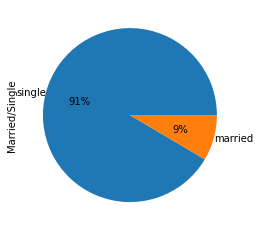

In [42]:
defaulters['Married/Single'].value_counts().plot.pie(autopct = '%1.0f%%', labeldistance = 1)

### Абсолютное большинство неплательщиков одиноки.

In [59]:
loan.groupby('Married/Single')['Risk_Flag'].value_counts()

Married/Single  Risk_Flag
married         0             23092
                1              2636
single          0            197912
                1             28360
Name: Risk_Flag, dtype: int64

### Хотя, если смотреть в разрезе группы по ссемейному статусу, проценты не сильно отличаются. 11% из женатых/замужних людей не выплачивают кредиты и 14% из одиноких.

#### Проанализируем аналогично оставшиеся параметры

In [44]:
defaulters['House_Ownership'].value_counts()

rented          29121
owned            1160
norent_noown      715
Name: House_Ownership, dtype: int64

### Абсолютное большинство неплательщиков арендуют дома, в которых живут

In [45]:
defaulters['Car_Ownership'].value_counts()

no     22561
yes     8435
Name: Car_Ownership, dtype: int64

### Абсолютное большинство неплательщиков не имеет машины

In [46]:
defaulters['Profession'].value_counts()

Police_officer                826
Software_Developer            750
Air_traffic_controller        715
Surveyor                      714
Physician                     710
Army_officer                  709
Hotel_Manager                 701
Technical_writer              697
Chartered_Accountant          690
Scientist                     690
Computer_hardware_engineer    690
Geologist                     674
Statistician                  671
Secretary                     660
Psychologist                  657
Biomedical_Engineer           654
Magistrate                    643
Aviator                       642
Flight_attendant              634
Comedian                      629
Civil_engineer                627
Lawyer                        624
Technician                    624
Computer_operator             619
Fashion_Designer              612
Firefighter                   612
Architect                     611
Microbiologist                607
Drafter                       605
Consultant    

### Однозначно определить профессию неплательщиков трудно

In [47]:
defaulters['CITY'].value_counts()

Kochi               243
Satna               232
Buxar[37]           228
Srinagar            216
Indore              212
                   ... 
Latur                23
Katni                21
Bijapur              20
Sultan_Pur_Majra     18
Gandhinagar          17
Name: CITY, Length: 317, dtype: int64

In [48]:
defaulters['STATE'].value_counts()

Uttar_Pradesh        3343
West_Bengal          3009
Andhra_Pradesh       2935
Maharashtra          2895
Bihar                2583
Madhya_Pradesh       2180
Tamil_Nadu           1706
Gujarat              1343
Rajasthan            1292
Jharkhand            1195
Karnataka            1189
Haryana               980
Telangana             979
Kerala                970
Assam                 930
Odisha                664
Delhi                 574
Chhattisgarh          511
Punjab                425
Jammu_and_Kashmir     283
Manipur               183
Puducherry            167
Tripura               136
Uttarakhand           133
Himachal_Pradesh      111
Uttar_Pradesh[5]       97
Mizoram                94
Chandigarh             61
Sikkim                 28
Name: STATE, dtype: int64

### Города и штаты не выделяют группу неплательщиков из конкретного региона, т.к. первые топ 5 уже покрывают карту Индии и на юге, и на севере почти полностью

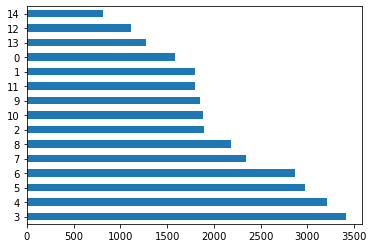

In [56]:
cur_job_y = defaulters['CURRENT_JOB_YRS'].value_counts().plot.barh()

### Большая часть людей, не выплачивающих кредиты, имеют стаж от 3 до 8 лет на текущем месте работы

In [50]:
defaulters['CURRENT_HOUSE_YRS'].value_counts()

11    6483
12    6304
13    6182
10    6082
14    5945
Name: CURRENT_HOUSE_YRS, dtype: int64

### Время проживания в настоящем месте пребывания не является показательным при описании портрета неплательщика

### Попробуем построить портрет неплательщика

### Для этого отфильтруем наш датафрейм по категориям, которые ярко выражены у неплательщиков: Married/Single, House_Ownership, Car_Ownership

In [79]:
defaulters[(defaulters['Married/Single'] == 'single') & (defaulters['House_Ownership'] == 'rented') & (defaulters['Car_Ownership'] == 'no')]

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Income category
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Высокий
14,15,9420838,48,6,single,rented,no,Technical_writer,Madurai,Tamil_Nadu,6,10,1,Очень высокий
17,18,3666346,56,12,single,rented,no,Politician,Bhusawal,Maharashtra,12,11,1,Средний
28,29,8832725,64,5,single,rented,no,Biomedical_Engineer,Pondicherry,Puducherry,5,11,1,Очень высокий
42,43,9760667,63,17,single,rented,no,Chartered_Accountant,Khandwa,Madhya_Pradesh,13,12,1,Очень высокий
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251973,251974,1244622,35,15,single,rented,no,Psychologist,Alwar,Rajasthan,3,11,1,Ниже среднего
251977,251978,1330613,63,19,single,rented,no,Engineer,Purnia[26],Bihar,13,12,1,Ниже среднего
251981,251982,1796713,47,2,single,rented,no,Technician,Kolhapur,Maharashtra,2,12,1,Ниже среднего
251982,251983,3182290,52,2,single,rented,no,Drafter,Naihati,West_Bengal,2,10,1,Ниже среднего


In [80]:
d_sorted = defaulters[(defaulters['Married/Single'] == 'single') & (defaulters['House_Ownership'] == 'rented') & (defaulters['Car_Ownership'] == 'no')]

### Изучим описательные статистики оставшихся категорий в отсортированном датафрейме

In [83]:
d_sorted['Age'].describe()

count    19353.000000
mean        48.637782
std         17.562634
min         21.000000
25%         33.000000
50%         48.000000
75%         64.000000
max         79.000000
Name: Age, dtype: float64

In [84]:
d_sorted['Age'].mode()

0    22
Name: Age, dtype: int64

In [85]:
d_sorted['Income category'].value_counts()

Ниже среднего    5480
Очень высокий    5205
Средний          3815
Высокий          3788
Низкий           1065
Name: Income category, dtype: int64

In [87]:
d_sorted['Experience'].describe()

count    19353.000000
mean         9.620627
std          6.112621
min          0.000000
25%          4.000000
50%         10.000000
75%         15.000000
max         20.000000
Name: Experience, dtype: float64

In [88]:
d_sorted['Profession'].value_counts()

Physician                     543
Police_officer                540
Army_officer                  516
Psychologist                  470
Software_Developer            468
Chartered_Accountant          458
Computer_hardware_engineer    438
Air_traffic_controller        437
Hotel_Manager                 437
Consultant                    436
Microbiologist                435
Magistrate                    432
Biomedical_Engineer           429
Flight_attendant              425
Technical_writer              422
Chemical_engineer             416
Civil_engineer                415
Architect                     409
Secretary                     403
Artist                        403
Surveyor                      394
Lawyer                        394
Statistician                  392
Scientist                     390
Chef                          390
Fashion_Designer              389
Comedian                      387
Mechanical_engineer           385
Geologist                     375
Web_designer  

In [90]:
d_sorted['STATE'].value_counts()

Uttar_Pradesh        2046
West_Bengal          1957
Andhra_Pradesh       1925
Maharashtra          1763
Bihar                1654
Madhya_Pradesh       1380
Tamil_Nadu           1047
Rajasthan             886
Karnataka             861
Gujarat               721
Jharkhand             712
Assam                 608
Haryana               594
Kerala                589
Telangana             530
Odisha                420
Delhi                 341
Chhattisgarh          245
Punjab                245
Jammu_and_Kashmir     241
Manipur               165
Puducherry            109
Himachal_Pradesh       85
Tripura                61
Uttarakhand            53
Mizoram                49
Chandigarh             36
Uttar_Pradesh[5]       19
Sikkim                 11
Name: STATE, dtype: int64

In [91]:
d_sorted['CURRENT_JOB_YRS'].describe()

count    19353.000000
mean         6.193768
std          3.792026
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         14.000000
Name: CURRENT_JOB_YRS, dtype: float64

In [92]:
d_sorted['CURRENT_JOB_YRS'].mode()

0    3
Name: CURRENT_JOB_YRS, dtype: int64

In [93]:
d_sorted['CURRENT_HOUSE_YRS'].describe()

count    19353.000000
mean        11.975146
std          1.400611
min         10.000000
25%         11.000000
50%         12.000000
75%         13.000000
max         14.000000
Name: CURRENT_HOUSE_YRS, dtype: float64

In [94]:
d_sorted['CURRENT_HOUSE_YRS'].mode()

0    11
Name: CURRENT_HOUSE_YRS, dtype: int64

## Проанализировав описательные статистики, можно составить портрет типичного неплательщика

In [95]:
from tabulate import tabulate

In [100]:
mydata = [
    ['Возраст', '20-30'],
    ['Доход', 'Ниже среднего, Очень высокий'],
    ['Семейный статус', 'Одиноки'],
    ['Штат проживания', 'Уттар-Прадеш, Западная Бенгалия, Андхра-Прадеш, Махараштра, Бихар, Мадхья-Прадеш ,Тамилнад'],
    ['Жильё', 'Арендованное'],
    ['Наличие автомобиля', 'Нет'],
    ['Рабочий стаж', '3-10 лет'],
    ['Стаж на текущем месте работы', '3-6 лет'],
    ['Кол-во времени проживания на текущем месте', '11'],
    ['Профессия', 'Разнообразный род деятельности']
]

head = ['Фактор', 'Описание']
print(tabulate(mydata, headers=head, tablefmt='grid'))

+--------------------------------------------+--------------------------------------------------------------------------------------------+
| Фактор                                     | Описание                                                                                   |
+============================================+============================================================================================+
| Возраст                                    | 20-30                                                                                      |
+--------------------------------------------+--------------------------------------------------------------------------------------------+
| Доход                                      | Ниже среднего, Очень высокий                                                               |
+--------------------------------------------+--------------------------------------------------------------------------------------------+
| Семейный статус   

### В таблице представлено описание портрета неплательщика. На таких клиентов компании необходимо обращать внимание, прежде чем выдать кредит